In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.1 MB/s eta 0:00:00


<ipython-input-6-ef722db1819a>:46: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_holiday'] = df['date'].isin(us_holidays).astype(int)
<ipython-input-6-ef722db1819a>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction_catboost'] = model_catboost.predict(X_test)


CatBoost - MAE: 602.09, RMSE: 782.89, R²: 0.97, MAPE: 1.93


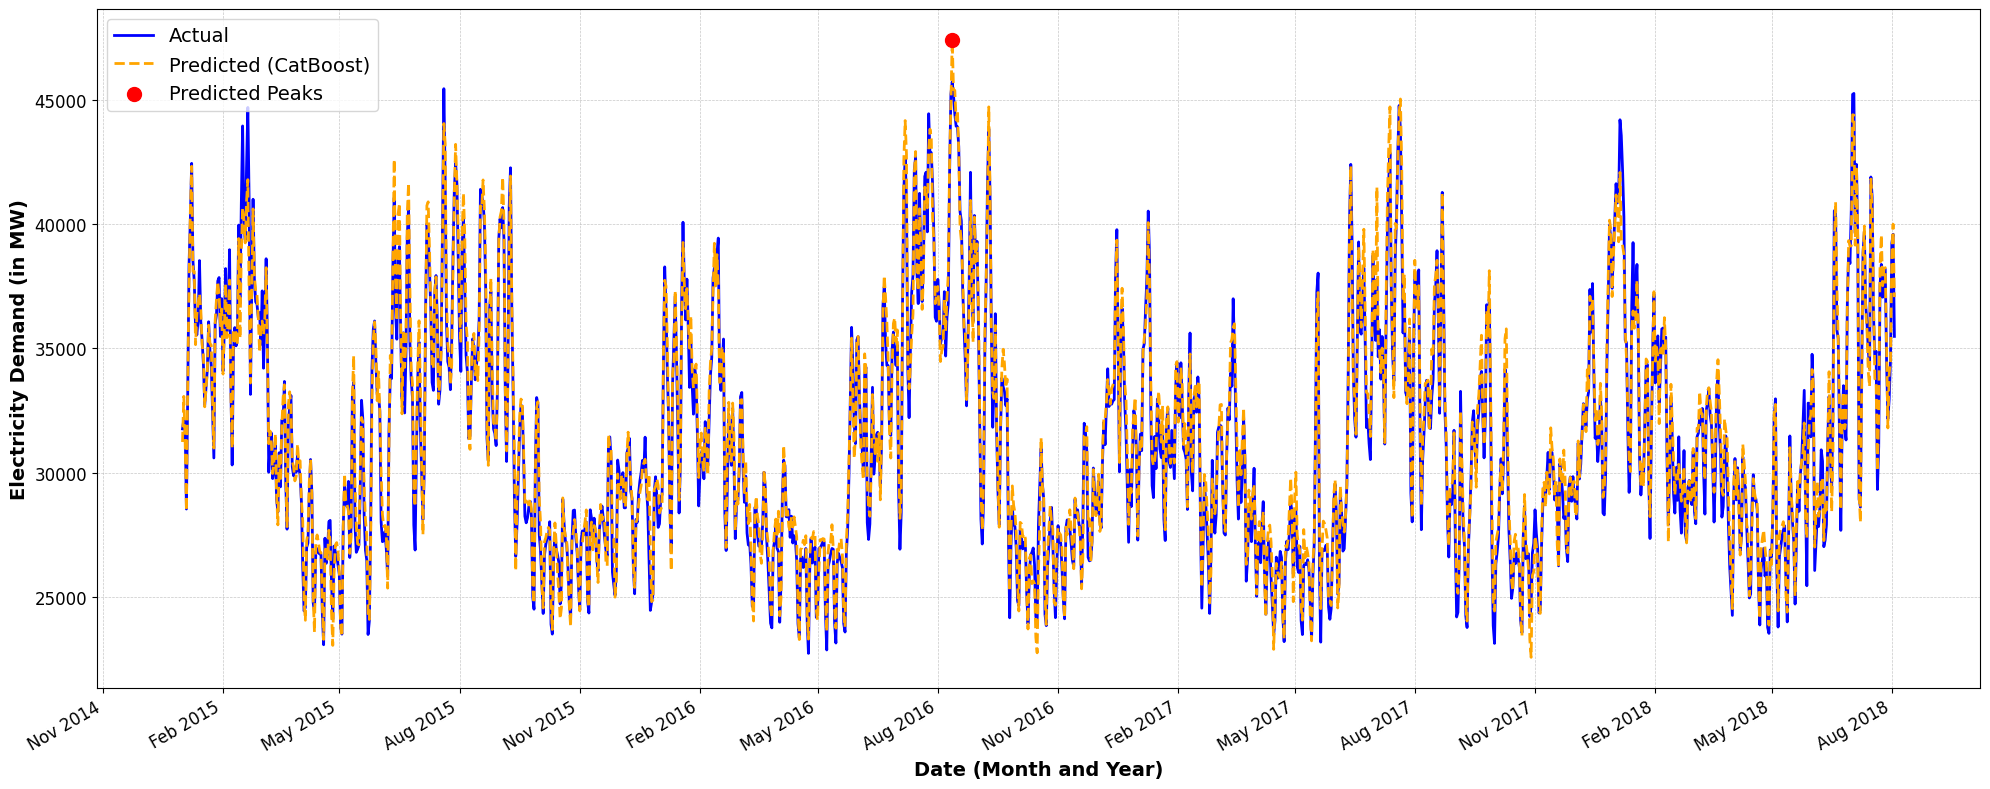

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import holidays
from catboost import CatBoostRegressor

pjme_df = pd.read_csv('PJMEhourly.csv')
t10yie_df = pd.read_csv('T10YIE.csv')
weather_df = pd.read_csv('weather.csv')
unrate_df = pd.read_csv('UNRATE.csv')

pjme_df.columns = ["Datetime", "PJME_MW"]
pjme_df['Datetime'] = pd.to_datetime(pjme_df['Datetime'])
pjme_df.set_index('Datetime', inplace=True)

pjme_daily = pjme_df.resample('D').mean().reset_index()
pjme_daily['date'] = pd.to_datetime(pjme_daily['Datetime'].dt.date)

t10yie_df['Date'] = pd.to_datetime(t10yie_df['Date'], dayfirst=True, format='%d-%m-%Y')
t10yie_df = t10yie_df[['Date', 'T10YIE']]
t10yie_df.rename(columns={'Date': 'date'}, inplace=True)

weather_df.columns = weather_df.columns.str.strip()
weather_df['Date'] = pd.to_datetime(weather_df['Date'], dayfirst=True, format='%d-%m-%Y')
weather_df.rename(columns={'Date': 'date'}, inplace=True)
weather_df = weather_df[['date', 'Average Temp (F)', 'Average Relative Humidity (%)']]
weather_df.rename(columns={'Average Temp (F)': 'Temperature', 'Average Relative Humidity (%)': 'Humidity'}, inplace=True)

unrate_df['DATE'] = pd.to_datetime(unrate_df['DATE'], format='%Y-%m-%d')
unrate_df.rename(columns={'DATE': 'date', 'UNRATE': 'unemployment_rate'}, inplace=True)

df_merged = pd.merge(pjme_daily, t10yie_df, on='date', how='left')
df_merged = pd.merge(df_merged, weather_df, on='date', how='left')
df_merged = pd.merge(df_merged, unrate_df[['date', 'unemployment_rate']], on='date', how='left')

us_holidays = holidays.US(years=range(2002, 2019))

def create_features(df):
    df['dayofweek'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['is_holiday'] = df['date'].isin(us_holidays).astype(int)
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    df['lag_1'] = df['PJME_MW'].shift(1)
    df['lag_7'] = df['PJME_MW'].shift(7)
    df['lag_14'] = df['PJME_MW'].shift(14)
    df['lag_30'] = df['PJME_MW'].shift(30)
    df['lag_60'] = df['PJME_MW'].shift(60)
    df['rolling_mean_7d'] = df['PJME_MW'].rolling(window=7).mean()
    df['rolling_mean_14d'] = df['PJME_MW'].rolling(window=14).mean()
    df['rolling_mean_30d'] = df['PJME_MW'].rolling(window=30).mean()
    return df

df_merged = create_features(df_merged)

numeric_columns = ['PJME_MW', 'T10YIE', 'Temperature', 'Humidity', 'unemployment_rate']
df_merged[numeric_columns] = df_merged[numeric_columns].apply(pd.to_numeric, errors='coerce')
imputer = SimpleImputer(strategy='mean')
df_merged[numeric_columns] = imputer.fit_transform(df_merged[numeric_columns])
df_merged.dropna(inplace=True)

FEATURES = [
    'dayofweek', 'month', 'year', 'is_holiday', 'is_weekend',
    'lag_1', 'lag_7', 'lag_14', 'lag_30', 'lag_60',
    'rolling_mean_7d', 'rolling_mean_14d', 'rolling_mean_30d',
    'T10YIE', 'Temperature', 'Humidity', 'unemployment_rate'
]
TARGET = 'PJME_MW'

train = df_merged[df_merged['date'] < '2015-01-01']
test = df_merged[df_merged['date'] >= '2015-01-01']
X_train, y_train = train[FEATURES], train[TARGET]
X_test, y_test = test[FEATURES], test[TARGET]

model_catboost = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, random_seed=42, verbose=0)
model_catboost.fit(X_train, y_train)
test['prediction_catboost'] = model_catboost.predict(X_test)

mae_catboost = mean_absolute_error(y_test, test['prediction_catboost'])
rmse_catboost = np.sqrt(mean_squared_error(y_test, test['prediction_catboost']))
r2_catboost = r2_score(y_test, test['prediction_catboost'])
mape_catboost = np.mean(np.abs((y_test - test['prediction_catboost']) / y_test)) * 100

print(f'CatBoost - MAE: {mae_catboost:.2f}, RMSE: {rmse_catboost:.2f}, R²: {r2_catboost:.2f}, MAPE: {mape_catboost:.2f}')

peak_dates = test.loc[test['prediction_catboost'] == test['prediction_catboost'].max(), 'date']
peak_values = test.loc[test['prediction_catboost'] == test['prediction_catboost'].max(), 'prediction_catboost']

plt.figure(figsize=(20, 8))

plt.plot(test['date'], test[TARGET], label='Actual', color='blue', linewidth=2)
plt.plot(test['date'], test['prediction_catboost'], label='Predicted (CatBoost)', color='orange', linestyle='--', linewidth=2)

plt.scatter(peak_dates, peak_values, color='red', label='Predicted Peaks', zorder=5, s=100)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gcf().autofmt_xdate()

plt.xlabel('Date (Month and Year)', fontsize=14, fontweight='bold')
plt.ylabel('Electricity Demand (in MW)', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.legend(fontsize=14)
plt.tight_layout()

plt.show()



<ipython-input-7-708b113ac128>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction_rf'] = model_rf.predict(X_test)


Random Forest - MAE: 798.74, RMSE: 1044.03, R²: 0.95, MAPE: 2.58


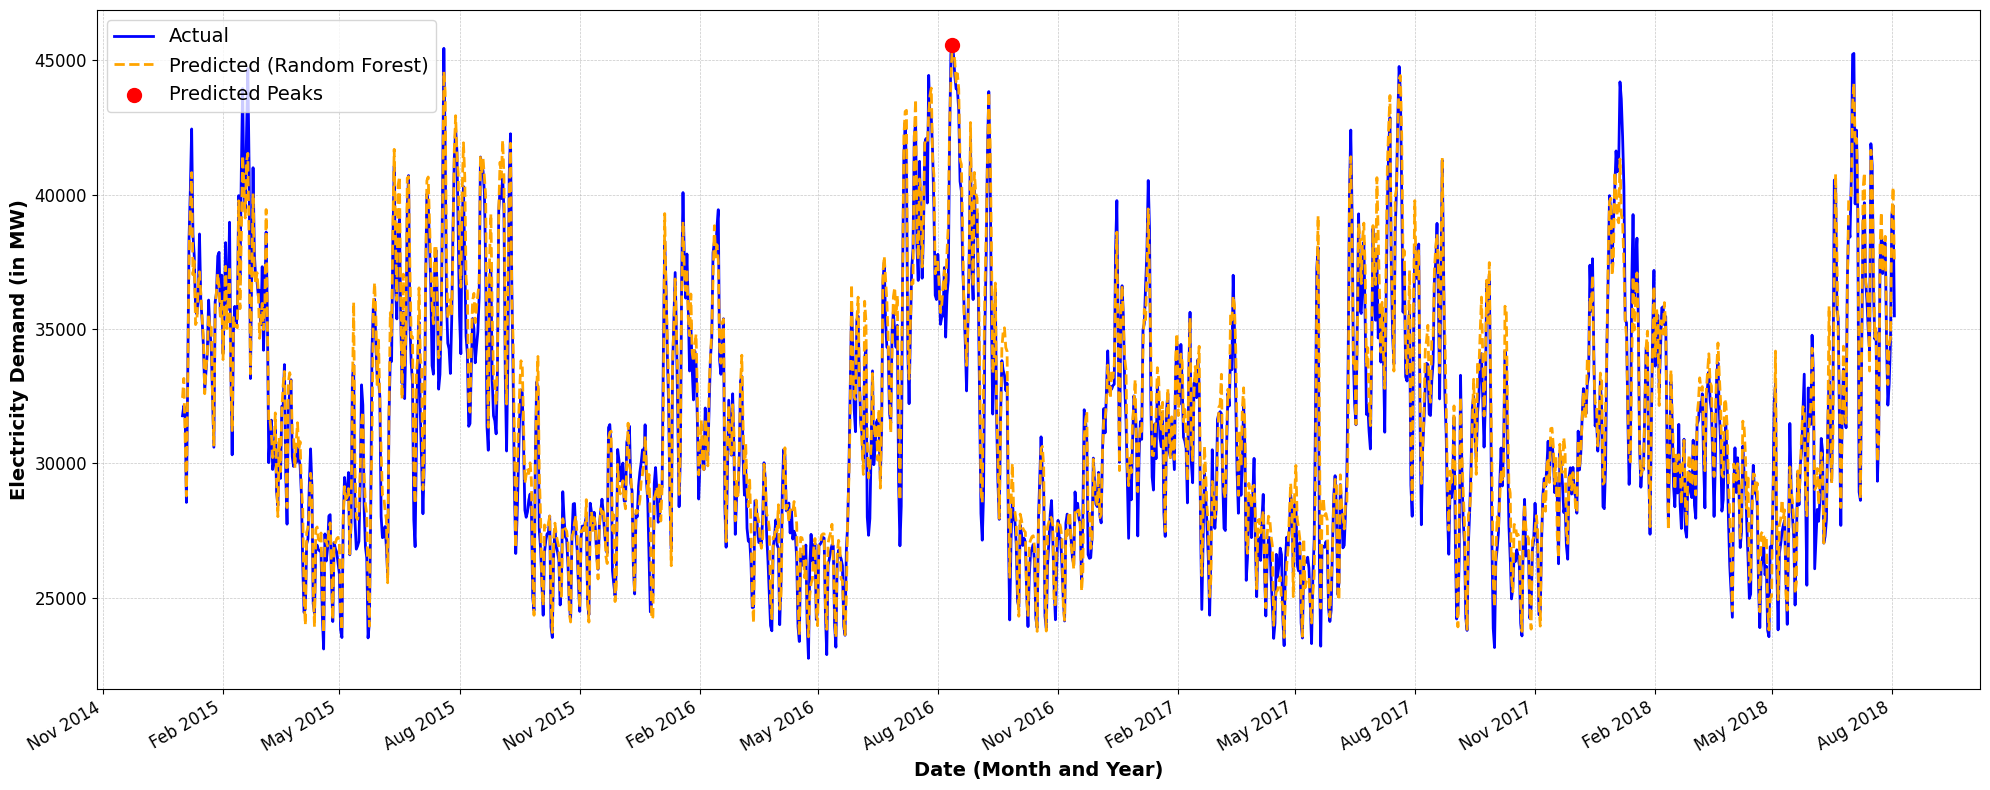

In [ ]:

from sklearn.ensemble import RandomForestRegressor


model_rf = RandomForestRegressor(n_estimators=1000, random_state=42)
model_rf.fit(X_train, y_train)
test['prediction_rf'] = model_rf.predict(X_test)


mae_rf = mean_absolute_error(y_test, test['prediction_rf'])
rmse_rf = np.sqrt(mean_squared_error(y_test, test['prediction_rf']))
r2_rf = r2_score(y_test, test['prediction_rf'])
mape_rf = np.mean(np.abs((y_test - test['prediction_rf']) / y_test)) * 100

print(f'Random Forest - MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}, R²: {r2_rf:.2f}, MAPE: {mape_rf:.2f}')


peak_dates_rf = test.loc[test['prediction_rf'] == test['prediction_rf'].max(), 'date']
peak_values_rf = test.loc[test['prediction_rf'] == test['prediction_rf'].max(), 'prediction_rf']

plt.figure(figsize=(20, 8))


plt.plot(test['date'], test[TARGET], label='Actual', color='blue', linewidth=2)
plt.plot(test['date'], test['prediction_rf'], label='Predicted (Random Forest)', color='orange', linestyle='--', linewidth=2)

plt.scatter(peak_dates_rf, peak_values_rf, color='red', label='Predicted Peaks', zorder=5, s=100)


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gcf().autofmt_xdate()


plt.xlabel('Date (Month and Year)', fontsize=14, fontweight='bold')
plt.ylabel('Electricity Demand (in MW)', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)


plt.legend(fontsize=14)
plt.tight_layout()

plt.show()



<ipython-input-8-ff30b71af961>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction_xgb'] = model_xgb.predict(X_test)


XGBoost - MAE: 671.21, RMSE: 879.52, R²: 0.97, MAPE: 2.14


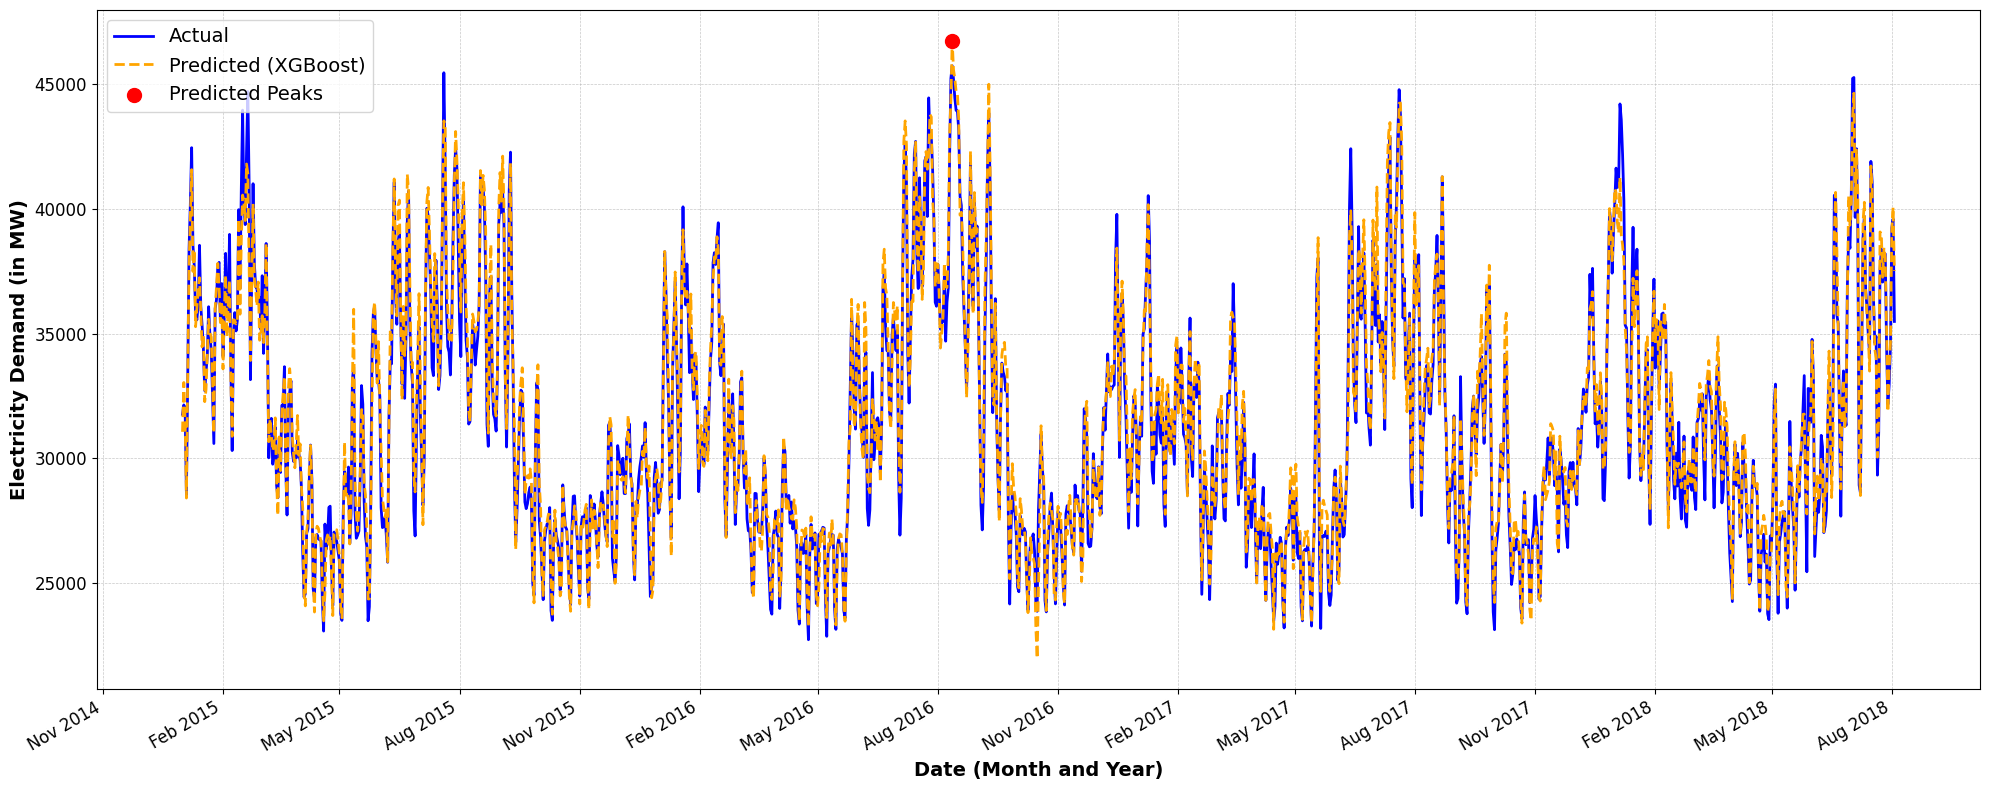

In [ ]:

import xgboost as xgb

model_xgb = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.1, max_depth=6, random_state=42)
model_xgb.fit(X_train, y_train)
test['prediction_xgb'] = model_xgb.predict(X_test)

mae_xgb = mean_absolute_error(y_test, test['prediction_xgb'])
rmse_xgb = np.sqrt(mean_squared_error(y_test, test['prediction_xgb']))
r2_xgb = r2_score(y_test, test['prediction_xgb'])
mape_xgb = np.mean(np.abs((y_test - test['prediction_xgb']) / y_test)) * 100

print(f'XGBoost - MAE: {mae_xgb:.2f}, RMSE: {rmse_xgb:.2f}, R²: {r2_xgb:.2f}, MAPE: {mape_xgb:.2f}')


peak_dates_xgb = test.loc[test['prediction_xgb'] == test['prediction_xgb'].max(), 'date']
peak_values_xgb = test.loc[test['prediction_xgb'] == test['prediction_xgb'].max(), 'prediction_xgb']


plt.figure(figsize=(20, 8))


plt.plot(test['date'], test[TARGET], label='Actual', color='blue', linewidth=2)
plt.plot(test['date'], test['prediction_xgb'], label='Predicted (XGBoost)', color='orange', linestyle='--', linewidth=2)


plt.scatter(peak_dates_xgb, peak_values_xgb, color='red', label='Predicted Peaks', zorder=5, s=100)


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gcf().autofmt_xdate()

plt.xlabel('Date (Month and Year)', fontsize=14, fontweight='bold')
plt.ylabel('Electricity Demand (in MW)', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)


plt.legend(fontsize=14)
plt.tight_layout()

plt.show()


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2789
[LightGBM] [Info] Number of data points in the train set: 4688, number of used features: 17
[LightGBM] [Info] Start training from score 32308.642721


<ipython-input-9-ccea1e6e4818>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction_lgbm'] = model_lgbm.predict(X_test)


LightGBM - MAE: 721.92, RMSE: 919.79, R²: 0.96, MAPE: 2.31


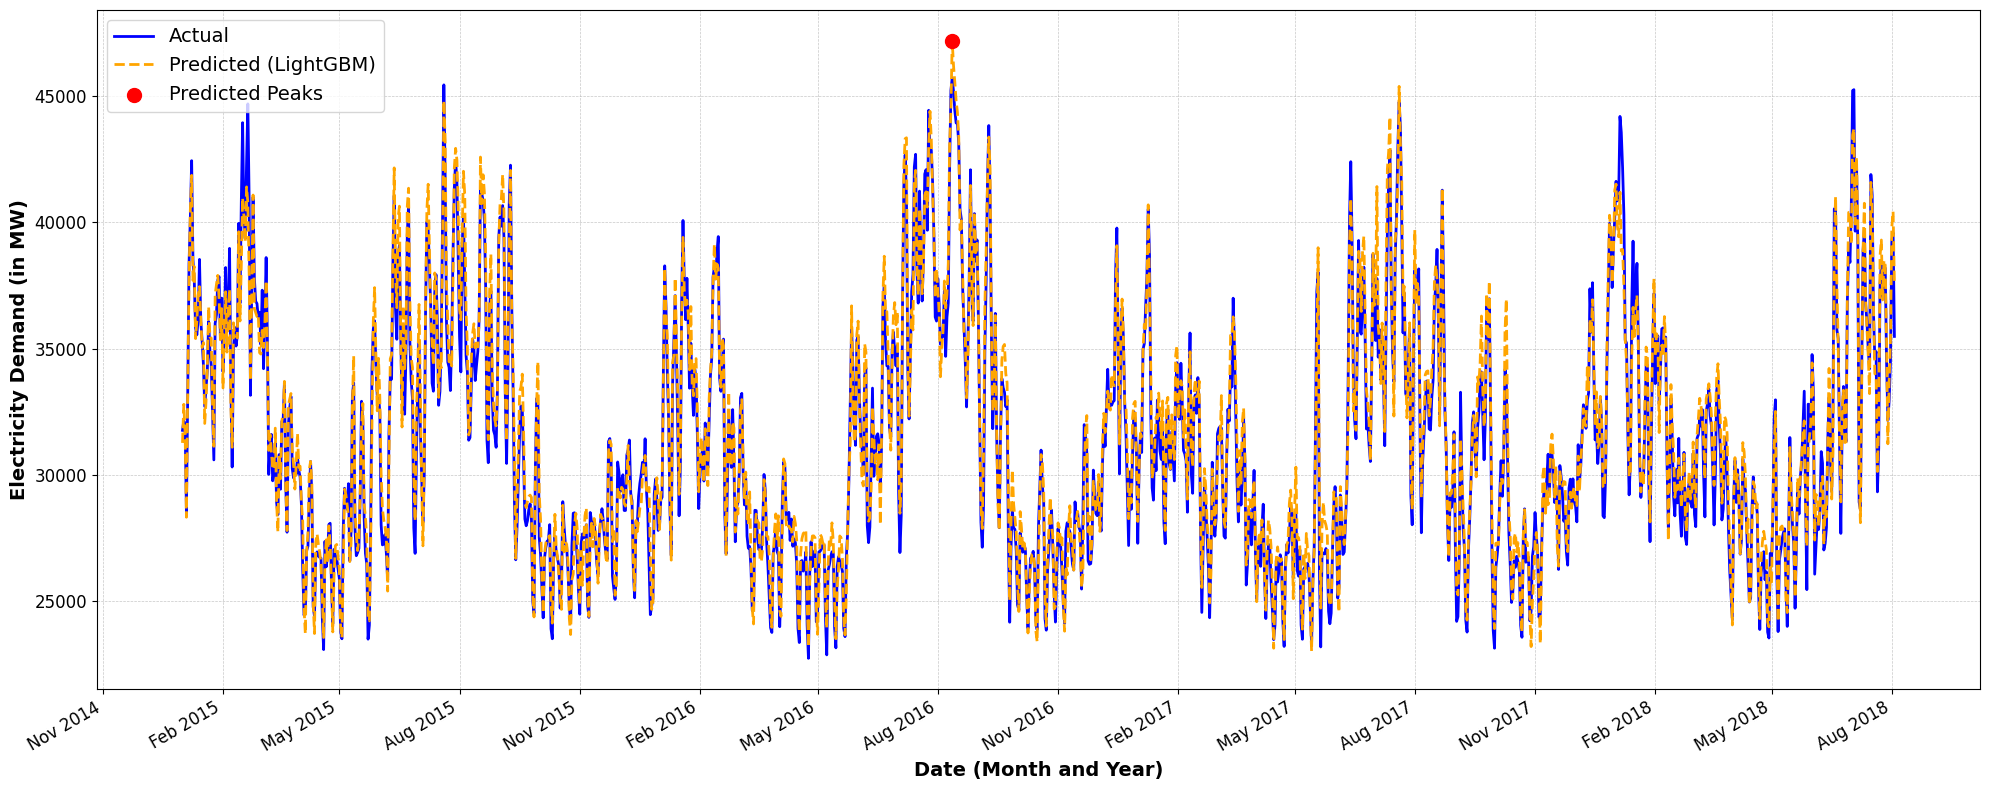

In [ ]:

import lightgbm as lgb

model_lgbm = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.1, random_state=42)
model_lgbm.fit(X_train, y_train)
test['prediction_lgbm'] = model_lgbm.predict(X_test)

mae_lgbm = mean_absolute_error(y_test, test['prediction_lgbm'])
rmse_lgbm = np.sqrt(mean_squared_error(y_test, test['prediction_lgbm']))
r2_lgbm = r2_score(y_test, test['prediction_lgbm'])
mape_lgbm = np.mean(np.abs((y_test - test['prediction_lgbm']) / y_test)) * 100

print(f'LightGBM - MAE: {mae_lgbm:.2f}, RMSE: {rmse_lgbm:.2f}, R²: {r2_lgbm:.2f}, MAPE: {mape_lgbm:.2f}')


peak_dates_lgbm = test.loc[test['prediction_lgbm'] == test['prediction_lgbm'].max(), 'date']
peak_values_lgbm = test.loc[test['prediction_lgbm'] == test['prediction_lgbm'].max(), 'prediction_lgbm']


plt.figure(figsize=(20, 8))


plt.plot(test['date'], test[TARGET], label='Actual', color='blue', linewidth=2)
plt.plot(test['date'], test['prediction_lgbm'], label='Predicted (LightGBM)', color='orange', linestyle='--', linewidth=2)


plt.scatter(peak_dates_lgbm, peak_values_lgbm, color='red', label='Predicted Peaks', zorder=5, s=100)


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gcf().autofmt_xdate()


plt.xlabel('Date (Month and Year)', fontsize=14, fontweight='bold')
plt.ylabel('Electricity Demand (in MW)', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)


plt.legend(fontsize=14)
plt.tight_layout()

plt.show()
